# Kaggle Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud 

# Details: https://scikit-learn.org/stable/modules/feature_selection.html


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [22]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.feature_selection import SelectFromModel,SelectKBest, f_classif, mutual_info_classif,SelectPercentile,SelectFwe,SelectFdr,SelectFpr,RFE,RFECV
from sklearn.metrics import auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
import time

In [4]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X = df.drop(['Class','Time'],axis=1)
y = df['Class']

# -------------------------------------------------------------------------------------------------------

# Univariate Feature Selection 

## Select K-Best - f_classif

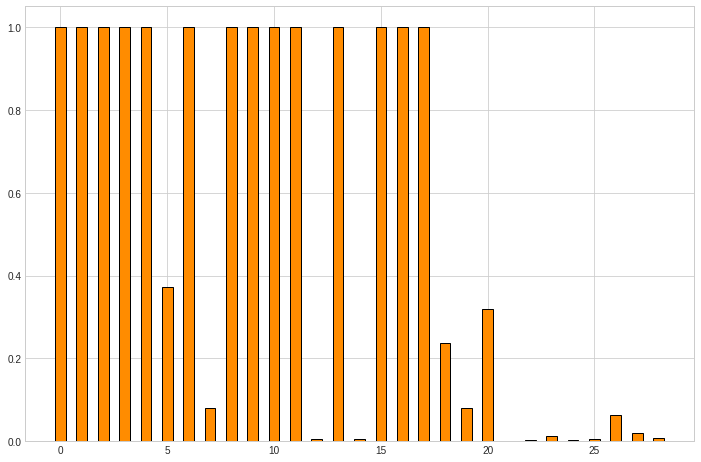

In [6]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
#selector.transform(X_train)
pvalues = selector.pvalues_.copy()
for i in range(len(pvalues)):
    if pvalues[i] == 0: pvalues[i] = 1e-320
scores = -np.log10(pvalues)
scores /= scores.max()
plt.figure(figsize=(12,8))
plt.bar(np.arange(X.shape[-1]), scores, width=.5,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
plt.show()

### Worst columns 

In [7]:
np.where(scores < 0.4)


(array([ 5,  7, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)

# -------------------------------------------------------------------------------------------------------

## Select K-Best - mutual_info_classif

In [8]:
selector = SelectKBest(mutual_info_classif, k=14)
selector.fit(X, y)
#selector.transform(X_train)

SelectKBest(k=14, score_func=<function mutual_info_classif at 0x7f41ac5d9dd0>)

### Worst columns 

In [9]:
np.where(selector.get_support()==False)

(array([ 0,  4,  5,  7, 12, 14, 18, 19, 21, 22, 23, 24, 25, 27, 28]),)

# -------------------------------------------------------------------------------------------------------

#  False Positive Rate - SelectFpr - f_classif

In [10]:
selector = SelectFpr(f_classif)
selector.fit(X, y)
#selector.transform(X_train)

SelectFpr(alpha=0.05, score_func=<function f_classif at 0x7f41ac5c95f0>)

### Worst columns 

In [11]:
np.where(selector.get_support()==False)

(array([21, 22, 24]),)

# -------------------------------------------------------------------------------------------------------

#  False Discovery Rate - SelectFdr - f_classif

In [12]:
selector = SelectFdr(f_classif)
selector.fit(X, y)
#selector.transform(X_train)

SelectFdr(alpha=0.05, score_func=<function f_classif at 0x7f41ac5c95f0>)

### Worst columns 

In [13]:
np.where(selector.get_support()==False)

(array([21, 22, 24]),)

# -------------------------------------------------------------------------------------------------------

#  Family Wise Error - SelectFwe - f_classif

In [14]:
selector = SelectFwe(f_classif)
selector.fit(X, y)
#selector.transform(X_train)

SelectFwe(alpha=0.05, score_func=<function f_classif at 0x7f41ac5c95f0>)

### Worst columns 

In [15]:
np.where(selector.get_support()==False)

(array([12, 14, 21, 22, 24, 25, 28]),)

# -------------------------------------------------------------------------------------------------------

## Drop columns [ 0,  4,  5,7, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28] and run the models 

In [16]:
X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [17]:
X = X.drop(['V1','V5', 'V6','V8','V13','V15','V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],axis=1)

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

In [20]:
dict_classifiers = {
    'KNeighbors': KNeighborsClassifier(n_jobs=3),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=3),
    'Logistic': LogisticRegression(solver='liblinear'),
    'Stochastic GD': SGDClassifier(loss='log',n_jobs=3, random_state=42,fit_intercept=False),
    'LinearSVM': LinearSVC(dual=False),
}
classifiers_names = list(dict_classifiers.keys())
classifiers_values = list(dict_classifiers.values())

In [26]:
#(clf, X, y_true)
def auc_score(model,X_test,y_test):
    y_test_pred = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred[:,1])
    return auc(recall, precision)

In [27]:
def auc_score_2(model,X_test,y_test):
    y_test_pred = model.decision_function(X_test)
    avg =  average_precision_score(y_test, y_test_pred)
    return avg

In [21]:
def benchmark(scaler,classifier,name=None):
    pipe = make_pipeline(scaler,classifier)
    pipe.fit(X_train,y_train)
    
    if name == 'LinearSVM':
        y_test_pred = pipe.decision_function(X_test)
        average_precision = average_precision_score(y_test, y_test_pred)
  #      print('AUC {} = {}'.format(name,average_precision))
        return average_precision
    else:
        y_test_pred = pipe.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred[:,1])
        _auc = auc(recall, precision)
  #      print('AUC {} = {}'.format(name,_auc))
        return _auc
    

In [23]:
t0 = time.time()
for key,value in zip(classifiers_names,classifiers_values):
    print('----'*8+f'{key}'+'----'*8)
    _auc=benchmark(StandardScaler(),value,key)
    print(f'AUC = {_auc}')

--------------------------------KNeighbors--------------------------------
AUC = 0.8860948299422249
--------------------------------Random Forest--------------------------------
AUC = 0.8454333843245458
--------------------------------Logistic--------------------------------
AUC = 0.7663408648179064
--------------------------------Stochastic GD--------------------------------
AUC = 0.7325940856817609
--------------------------------LinearSVM--------------------------------
AUC = 0.7784921926593883


# -------------------------------------------------------------------------------------------------------

# Feature Selection - Recursive feature elimination

### Classificators have to had coef_ attribute or a feature_importances_ attribute

In [28]:
dict_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=3),
    'Logistic': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'LinearSVM': LinearSVC(dual=False),
}
classifiers_names = list(dict_classifiers.keys())
classifiers_values=list(dict_classifiers.values())

In [29]:
t0=time.time()
ranks_rfe = []
for name,classifier in zip(classifiers_names,classifiers_values):
    print(name)
    selector = RFE(classifier,step=1,n_features_to_select=1,verbose=1)
    selector = selector.fit(X, y)
    print('Features Ranking=',selector.ranking_,'\n')  #ranking_[i] corresponds to the ranking position of the i-th feature
    ranks_rfe.append(selector.ranking_)
    #print('Choosen Features=',X.columns[selector.support_])
    
print('total time taken = ',time.time()-t0)



Random Forest
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator wit

In [30]:
#Best columns for each classifier
best_cols=np.argsort(ranks_rfe,axis=1)
best_cols

array([[16, 11, 13,  9, 10, 15,  6,  3,  8, 17, 25, 19, 20,  5,  2,  0,
        26, 14, 18,  7,  1, 27, 28, 12,  4, 21, 23, 24, 22],
       [13,  3, 21, 20,  9, 12, 15,  7, 26,  8, 22, 19, 27, 23,  4, 24,
        14,  5, 18,  0,  1,  6, 25, 11,  2, 10, 16, 17, 28],
       [16,  9, 13, 11, 25, 26,  6,  3, 15, 12, 14, 23, 18,  0, 19, 20,
         7, 21, 22,  4,  8, 27, 10,  2, 24,  5, 17, 28,  1],
       [13, 16,  9, 15,  3, 12,  8, 24, 20, 26, 19,  0,  7, 21, 27,  1,
         6, 17, 18, 11, 23, 22, 10,  2, 14,  4, 25,  5, 28]])

In [31]:
aux=0
AUCS = []
for name,classifier in zip(classifiers_names,classifiers_values):
    cols = best_cols[aux]
    for i in range(2,len(cols)):
        print(name,'with cols',cols[:i])
        X = df.drop(['Class','Time'],axis=1)
        X = X[X.columns[cols[:i]]]
        X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

        print('Training')
        _auc=benchmark(StandardScaler(),classifier,name)
        AUCS.append(_auc)
        print('AUC {} = {} \n'.format(name,_auc))
    aux+=1
  

Random Forest with cols [16 11]
Training
AUC Random Forest = 0.7815789222577672 

Random Forest with cols [16 11 13]
Training
AUC Random Forest = 0.8428244459121854 

Random Forest with cols [16 11 13  9]
Training
AUC Random Forest = 0.8462081390343636 

Random Forest with cols [16 11 13  9 10]
Training
AUC Random Forest = 0.8485162179150871 

Random Forest with cols [16 11 13  9 10 15]
Training
AUC Random Forest = 0.8481517322951917 

Random Forest with cols [16 11 13  9 10 15  6]
Training
AUC Random Forest = 0.8442123715541854 

Random Forest with cols [16 11 13  9 10 15  6  3]
Training
AUC Random Forest = 0.848684018917022 

Random Forest with cols [16 11 13  9 10 15  6  3  8]
Training
AUC Random Forest = 0.8554013979785466 

Random Forest with cols [16 11 13  9 10 15  6  3  8 17]
Training
AUC Random Forest = 0.8555221629021676 

Random Forest with cols [16 11 13  9 10 15  6  3  8 17 25]
Training
AUC Random Forest = 0.8583149986183738 

Random Forest with cols [16 11 13  9 10 15  6 

AUC Decision Tree = 0.7515594615175094 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8]
Training
AUC Decision Tree = 0.756141723240787 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8 27]
Training
AUC Decision Tree = 0.7414424785888554 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8 27 10]
Training
AUC Decision Tree = 0.7642846235462015 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8 27 10  2]
Training
AUC Decision Tree = 0.7516760497159969 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8 27 10  2
 24]
Training
AUC Decision Tree = 0.7599903948176364 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 22  4  8 27 10  2
 24  5]
Training
AUC Decision Tree = 0.7663082728460408 

Decision Tree with cols [16  9 13 11 25 26  6  3 15 12 14 23 18  0 19 20  7 21 

In [32]:
AUCS = np.array(AUCS).reshape(4,27)
columns = [str(i)+ ' columns' for i in list(range(2,29) )]
df_aucs_rfe = pd.DataFrame(AUCS,index=classifiers_names,columns=columns)
df_aucs_rfe.head()


,2 columns,3 columns,4 columns,5 columns,6 columns,7 columns,8 columns,9 columns,10 columns,11 columns,...,19 columns,20 columns,21 columns,22 columns,23 columns,24 columns,25 columns,26 columns,27 columns,28 columns
Random Forest,0.781579,0.842824,0.846208,0.848516,0.848152,0.844212,0.848684,0.855401,0.855522,0.858315,...,0.848560,0.861533,0.855107,0.861165,0.862886,0.864487,0.862992,0.864179,0.871471,0.862591
Logistic,0.666109,0.668080,0.703177,0.758192,0.763445,0.765363,0.782151,0.784892,0.785219,0.784496,...,0.787381,0.788232,0.789038,0.788304,0.788115,0.787719,0.787687,0.787526,0.787691,0.787682
Decision Tree,0.711365,0.740235,0.775840,0.769420,0.758581,0.723898,0.738848,0.750478,0.747462,0.763631,...,0.753899,0.751559,0.756142,0.741442,0.764285,0.751676,0.759990,0.766308,0.757933,0.741442
LinearSVM,0.701879,0.764188,0.764769,0.778548,0.781573,0.781099,0.780137,0.778209,0.779890,0.783080,...,0.793605,0.794551,0.795036,0.794584,0.794647,0.796498,0.796183,0.796784,0.796648,0.796502


In [33]:
#Max of each classifier and which column
print(df_aucs_rfe.max(axis=1),'\n')
print(df_aucs_rfe.idxmax(axis=1))

Random Forest    0.871471
Logistic         0.789038
Decision Tree    0.781759
LinearSVM        0.796784
dtype: float64 

Random Forest    27 columns
Logistic         21 columns
Decision Tree    12 columns
LinearSVM        26 columns
dtype: object


In [34]:
#Mean of each classifier
df_aucs_rfe.mean(axis=1)

Random Forest    0.852923
Logistic         0.772235
Decision Tree    0.753574
LinearSVM        0.785546
dtype: float64

In [35]:
# Max of each column
df_aucs_rfe.idxmax()

2 columns     Random Forest
3 columns     Random Forest
4 columns     Random Forest
5 columns     Random Forest
6 columns     Random Forest
7 columns     Random Forest
8 columns     Random Forest
9 columns     Random Forest
10 columns    Random Forest
11 columns    Random Forest
12 columns    Random Forest
13 columns    Random Forest
14 columns    Random Forest
15 columns    Random Forest
16 columns    Random Forest
17 columns    Random Forest
18 columns    Random Forest
19 columns    Random Forest
20 columns    Random Forest
21 columns    Random Forest
22 columns    Random Forest
23 columns    Random Forest
24 columns    Random Forest
25 columns    Random Forest
26 columns    Random Forest
27 columns    Random Forest
28 columns    Random Forest
dtype: object

In [36]:
#Random Forest values
df_aucs_rfe.max().sort_values(ascending=False)

27 columns    0.871471
24 columns    0.864487
26 columns    0.864179
25 columns    0.862992
23 columns    0.862886
28 columns    0.862591
20 columns    0.861533
22 columns    0.861165
11 columns    0.858315
13 columns    0.858075
17 columns    0.856324
10 columns    0.855522
9 columns     0.855401
21 columns    0.855107
18 columns    0.854969
16 columns    0.854905
12 columns    0.854751
14 columns    0.853509
15 columns    0.852001
8 columns     0.848684
19 columns    0.848560
5 columns     0.848516
6 columns     0.848152
4 columns     0.846208
7 columns     0.844212
3 columns     0.842824
2 columns     0.781579
dtype: float64

# -------------------------------------------------------------------------------------------------------

# Feature Selection - Recursive feature elimination with cross-validation:


In [38]:
t0=time.time()
scoring_parameters = [auc_score] *3 + [auc_score_2]
AUCS = []
ranks = []
for name,classifier,scorer in zip(classifiers_names,classifiers_values,scoring_parameters):
    X = df.drop(['Class','Time'],axis=1)
    print(name)
    selector = RFECV(classifier, step=1, cv=5,scoring=scorer,n_jobs=3,verbose=1)
    selector = selector.fit(X, y)
    print('Length of Choosen Features=',len(list(X.columns[selector.support_])))
    print('Choosen Features=',X.columns[selector.support_])
    print('Features Ranking=',selector.ranking_,'\n')  #ranking_[i] corresponds to the ranking position of the i-th feature
    ranks.append(selector.ranking_)
    
    X = selector.transform(X)
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

    _auc = benchmark(StandardScaler(), classifier,name)
    AUCS.append(_auc)
    print('AUC:',_auc)
    
print('total time taken = ',time.time()-t0)

Random Forest
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Length of Choosen Features= 22
Choosen Features= Index(['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V26', 'V27',
       'V28'],
      dtype='object')
Features Ranking= [1 1 1 1 4 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 5 8 6 7 1 1 1 2] 

AUC: 0.8618938621153773
Logistic
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with

In [39]:
AUCS = np.array(AUCS).reshape(4,1)
df_aucs_rfecv = pd.DataFrame(AUCS,index=classifiers_names,columns=['AUC'])
df_aucs_rfecv.head()

,AUC
Random Forest,0.861894
Logistic,0.787428
Decision Tree,0.778570
LinearSVM,0.796183


# -------------------------------------------------------------------------------------------------------

# Feature selection using SelectFromModel

In [352]:
t0=time.time()
aucs_rf,aucs_nei = [],[]

for name,classifier in zip(classifiers_names,classifiers_values):
    print('--'*10+f'{name} Select features'+'--'*10)
    for i in range(2,29):
        print('\n',i,' features')
        X = df.drop(['Class','Time'],axis=1)
        clf = classifier.fit(X,y)
        sfm = SelectFromModel(clf,prefit=True,threshold=-np.inf,max_features=i)
        X_transform = sfm.transform(X)
        
        print('Choosen Features',X.columns[sfm.get_support()])
        
        X_train, X_test, y_train, y_test=train_test_split(X_transform,y,test_size=0.33,random_state=42)
        Auc_rf = benchmark(StandardScaler(), RandomForestClassifier(random_state=42, n_jobs=3))
        print('Random Forest = ',Auc_rf)
        aucs_rf.append(Auc_rf)
        Auc_nei = benchmark(StandardScaler(), KNeighborsClassifier(n_jobs=3))
        print('Neighboors = ',Auc_nei)
        aucs_nei.append(Auc_nei)
        

print('\nTotal time taken:',time.time()-t0)

--------------------Random Forest Select features--------------------

 2  features
n_fea= 2
Choosen Features Index(['V12', 'V17'], dtype='object')
RF =  0.7746103581714108
Neighboors =  0.7916325366439652

 3  features
n_fea= 3
Choosen Features Index(['V12', 'V14', 'V17'], dtype='object')
RF =  0.8449287326066823
Neighboors =  0.84655518511996

 4  features
n_fea= 4
Choosen Features Index(['V10', 'V12', 'V14', 'V17'], dtype='object')
RF =  0.8512865932690484
Neighboors =  0.8677345402070807

 5  features
n_fea= 5
Choosen Features Index(['V10', 'V12', 'V14', 'V16', 'V17'], dtype='object')
RF =  0.8437573138969491
Neighboors =  0.8697743909878095

 6  features
n_fea= 6
Choosen Features Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')
RF =  0.850997392585656
Neighboors =  0.8840948013477871

 7  features
n_fea= 7
Choosen Features Index(['V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')
RF =  0.8456239669586894
Neighboors =  0.8892527442680929

 8  features

RF =  0.8702252602890408
Neighboors =  0.8732678195903234

 13  features
n_fea= 13
Choosen Features Index(['V4', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21', 'V22',
       'V24', 'V27', 'V28'],
      dtype='object')
RF =  0.8716765081827855
Neighboors =  0.8611392151879737

 14  features
n_fea= 14
Choosen Features Index(['V4', 'V6', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21', 'V22',
       'V24', 'V27', 'V28'],
      dtype='object')
RF =  0.8640727413880934
Neighboors =  0.8599292418977056

 15  features
n_fea= 15
Choosen Features Index(['V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21',
       'V22', 'V24', 'V27', 'V28'],
      dtype='object')
RF =  0.8674081978300274
Neighboors =  0.860428281890993

 16  features
n_fea= 16
Choosen Features Index(['V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V27', 'V28'],
      dtype='object')
RF =  0.8611686900442941
Neighboors =  0.8593765017181316

 17  

RF =  0.8645858651964775
Neighboors =  0.8519882679691124

 21  features
n_fea= 21
Choosen Features Index(['V1', 'V2', 'V4', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25', 'V27', 'V28'],
      dtype='object')
RF =  0.8657372258317448
Neighboors =  0.8561491952069938

 22  features
n_fea= 22
Choosen Features Index(['V1', 'V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14',
       'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25', 'V27',
       'V28'],
      dtype='object')
RF =  0.8600976481973144
Neighboors =  0.8630673872835343

 23  features
n_fea= 23
Choosen Features Index(['V1', 'V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25',
       'V27', 'V28'],
      dtype='object')
RF =  0.8563421419058738
Neighboors =  0.8656879286880914

 24  features
n_fea= 24
Choosen Features Index(['V1', 'V2', 'V3', 'V4', 'V

RF =  0.8480030441805692
Neighboors =  0.8406484888850572

 27  features
n_fea= 27
Choosen Features Index(['V1', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
RF =  0.8606505479467516
Neighboors =  0.8532445041567351

 28  features
n_fea= 28
Choosen Features Index(['V1', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
RF =  0.860771080940685
Neighboors =  0.8530175085317921

Total time taken: 9257.803010463715


In [366]:
aucs_rf = np.array(aucs_rf).reshape(4,27)
columns = [str(i)+ ' columns' for i in list(range(2,29) )]
df_aucs_rf = pd.DataFrame(aucs_rf,index=classifiers_names,columns=columns)
df_aucs_rf.head()

,2 columns,3 columns,4 columns,5 columns,6 columns,7 columns,8 columns,9 columns,10 columns,11 columns,...,19 columns,20 columns,21 columns,22 columns,23 columns,24 columns,25 columns,26 columns,27 columns,28 columns
Random Forest,0.774610,0.844929,0.851287,0.843757,0.850997,0.845624,0.847292,0.855346,0.850854,0.860424,...,0.855693,0.855924,0.847633,0.851872,0.859493,0.861490,0.870563,0.869855,0.867124,0.865796
Logistic,0.648870,0.789776,0.851284,0.848805,0.850163,0.841604,0.842180,0.848712,0.869203,0.860104,...,0.864856,0.865088,0.862432,0.857631,0.859937,0.853882,0.857903,0.850643,0.863101,0.860057
LinearSVM,0.648870,0.716962,0.831208,0.839570,0.870510,0.862520,0.870128,0.868870,0.877641,0.869642,...,0.863664,0.864586,0.865737,0.860098,0.856342,0.862483,0.862022,0.866847,0.859692,0.860057
Decision Tree,0.784721,0.844929,0.844899,0.839525,0.853920,0.852775,0.844077,0.843764,0.853392,0.854188,...,0.851686,0.863425,0.858445,0.859144,0.855619,0.858288,0.850045,0.848003,0.860651,0.860771


In [367]:
#Max of each classifier with RF and which column
print(df_aucs_rf.max(axis=1),'\n')
print(df_aucs_rf.idxmax(axis=1))

Random Forest    0.870563
Logistic         0.871677
LinearSVM        0.877641
Decision Tree    0.863425
dtype: float64 

Random Forest    25 columns
Logistic         13 columns
LinearSVM        10 columns
Decision Tree    20 columns
dtype: object


In [365]:
aucs_nei = np.array(aucs_nei).reshape(4,27)
columns = [str(i)+ ' columns' for i in list(range(2,29) )]
df_aucs_nei = pd.DataFrame(aucs_nei,index=classifiers_names,columns=columns)
df_aucs_nei.head()

,2 columns,3 columns,4 columns,5 columns,6 columns,7 columns,8 columns,9 columns,10 columns,11 columns,...,19 columns,20 columns,21 columns,22 columns,23 columns,24 columns,25 columns,26 columns,27 columns,28 columns
Random Forest,0.791633,0.846555,0.867735,0.869774,0.884095,0.889253,0.888588,0.887257,0.891920,0.882818,...,0.873944,0.866923,0.865057,0.866891,0.866891,0.851748,0.851748,0.847276,0.856188,0.851386
Logistic,0.648988,0.790091,0.863018,0.860632,0.864741,0.868724,0.858477,0.862238,0.861268,0.872809,...,0.863047,0.857855,0.860651,0.858081,0.858801,0.865909,0.862178,0.863301,0.869282,0.850271
LinearSVM,0.648988,0.705899,0.853742,0.855955,0.875647,0.886588,0.886200,0.890625,0.889380,0.892605,...,0.851764,0.851988,0.856149,0.863067,0.865688,0.857468,0.858849,0.852429,0.852429,0.850271
Decision Tree,0.814574,0.846555,0.849176,0.866575,0.849218,0.852368,0.862709,0.867681,0.874494,0.874848,...,0.846976,0.846976,0.844293,0.843872,0.841122,0.845863,0.840930,0.840648,0.853245,0.853018


In [368]:
#Max of each classifier with Neighboors and which column
print(df_aucs_nei.max(axis=1),'\n')
print(df_aucs_nei.idxmax(axis=1))

Random Forest    0.891920
Logistic         0.873268
LinearSVM        0.892605
Decision Tree    0.874848
dtype: float64 

Random Forest    10 columns
Logistic         12 columns
LinearSVM        11 columns
Decision Tree    11 columns
dtype: object


In [385]:
df_aucs_nei.loc['Random Forest'].values

array([0.79163254, 0.84655519, 0.86773454, 0.86977439, 0.8840948 ,
       0.88925274, 0.88858805, 0.8872573 , 0.89192013, 0.88281845,
       0.88097161, 0.88463608, 0.8763307 , 0.87718263, 0.87375607,
       0.87266196, 0.87249065, 0.87394357, 0.86692286, 0.86505736,
       0.8668908 , 0.8668908 , 0.8517477 , 0.8517477 , 0.84727564,
       0.85618845, 0.85138601])

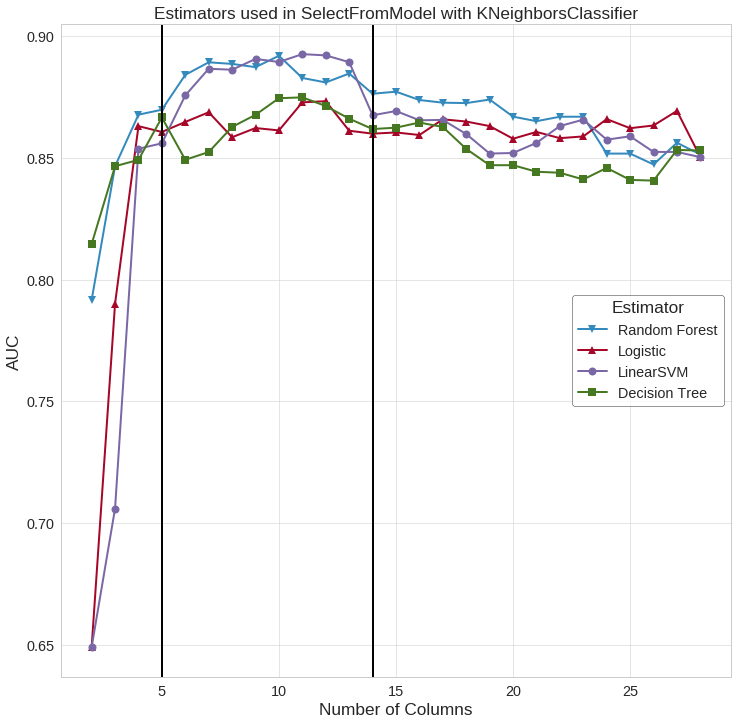

In [478]:
plt.figure(figsize=(12,12))
plt.title('Estimators used in SelectFromModel with KNeighborsClassifier',size='xx-large')
plt.xlabel('Number of Columns',size='xx-large')
plt.xticks(size='x-large')
plt.ylabel('AUC',size='xx-large')
plt.yticks(size='x-large')
x = range(2,29)
plt.plot(x,df_aucs_nei.loc['Random Forest'].values,label='Random Forest',marker='v',ms=8)
plt.plot(x,df_aucs_nei.loc['Logistic'].values,label='Logistic',marker='^',ms=8)
plt.plot(x,df_aucs_nei.loc['LinearSVM'].values,label='LinearSVM',marker='o',ms=8)
plt.plot(x,df_aucs_nei.loc['Decision Tree'].values,label='Decision Tree',marker='s',ms=8)
plt.legend(loc='center right',frameon=True,title='Estimator',title_fontsize='xx-large',fontsize='x-large',edgecolor='black')
plt.axvline(x=5,c='black')
plt.axvline(x=14,c='black')
plt.show()

# -------------------------------------------------------------------------------------------------------

# Tree-based feature selection

Feature ranking:
1. feature 16 (0.122521)
2. feature 13 (0.119930)
3. feature 11 (0.114580)
4. feature 10 (0.078671)
5. feature 15 (0.071918)
6. feature 9 (0.071467)
7. feature 17 (0.046683)
8. feature 3 (0.036408)
9. feature 2 (0.035013)
10. feature 8 (0.034518)
11. feature 6 (0.024117)
12. feature 18 (0.016627)
13. feature 20 (0.016051)
14. feature 1 (0.015332)
15. feature 0 (0.015182)
16. feature 25 (0.014721)
17. feature 4 (0.014572)
18. feature 19 (0.014211)
19. feature 7 (0.014118)
20. feature 5 (0.013806)
21. feature 21 (0.013215)
22. feature 14 (0.012930)
23. feature 26 (0.012856)
24. feature 23 (0.012479)
25. feature 12 (0.012476)
26. feature 28 (0.012213)
27. feature 27 (0.012009)
28. feature 24 (0.011732)
29. feature 22 (0.009645)


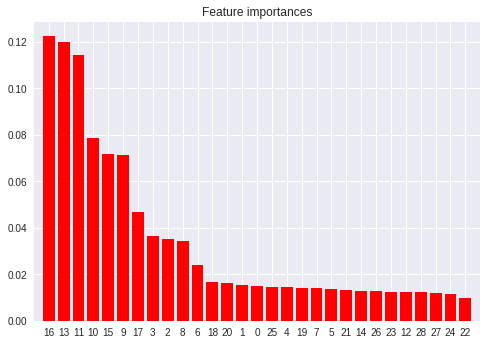

In [223]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=42)
X = df.drop(['Class','Time'],axis=1)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print(f'{f+1}. feature {indices[f]} ({importances[indices[f]]})')

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#['V1', 'V4', 'V9', 'V10', 'V14', 'V16', 'V17', 'V20', 'V21', 'V27','V28']
#['V1','V2','V3', 'V4','V5', 'V9', 'V10', 'V14','V15', 'V16', 'V17', 'V20', 'V21', 'V27','V28']

In [374]:
indices

array([16, 13, 11, 10, 15,  9, 17,  3,  2,  8,  6, 18, 20,  1,  0, 25,  4,
       19,  7,  5, 21, 14, 26, 23, 12, 28, 27, 24, 22])

In [371]:
dict_classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=3),
    'Neighboors': KNeighborsClassifier(n_jobs=3)
}
classifiers_names = list(dict_classifiers.keys())
classifiers_values=list(dict_classifiers.values())

In [375]:
aux=0
AUCS_tree = []
for name,classifier in zip(classifiers_names,classifiers_values):
    for i in range(2,len(indices)):
        print(f'{name},with {i} cols')
        X = df.drop(['Class','Time'],axis=1)
        X = X[X.columns[indices[:i]]]
        X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

        print('Training')
        _auc=benchmark(MaxAbsScaler(),classifier)
        AUCS_tree.append(_auc)
        print('AUC {} = {} \n'.format(name,_auc))
    aux+=1
  

Random Forest with cols [16 13]
Training
AUC Random Forest = 0.7846952646564788 

Random Forest with cols [16 13 11]
Training
AUC Random Forest = 0.843289050329807 

Random Forest with cols [16 13 11 10]
Training
AUC Random Forest = 0.8458326833038902 

Random Forest with cols [16 13 11 10 15]
Training
AUC Random Forest = 0.8372576286214788 

Random Forest with cols [16 13 11 10 15  9]
Training
AUC Random Forest = 0.847175608278906 

Random Forest with cols [16 13 11 10 15  9 17]
Training
AUC Random Forest = 0.8571249551698449 

Random Forest with cols [16 13 11 10 15  9 17  3]
Training
AUC Random Forest = 0.8611290870554829 

Random Forest with cols [16 13 11 10 15  9 17  3  2]
Training
AUC Random Forest = 0.8487989113414538 

Random Forest with cols [16 13 11 10 15  9 17  3  2  8]
Training
AUC Random Forest = 0.8520789512018598 

Random Forest with cols [16 13 11 10 15  9 17  3  2  8  6]
Training
AUC Random Forest = 0.8567712378238961 

Random Forest with cols [16 13 11 10 15  9 17  

In [376]:
AUCS_tree = np.array(AUCS_tree).reshape(2,27)
columns = [str(i)+ ' columns' for i in list(range(2,29) )]
df_aucs_tree = pd.DataFrame(AUCS_tree,index=classifiers_names,columns=columns)
df_aucs_tree.head()

,2 columns,3 columns,4 columns,5 columns,6 columns,7 columns,8 columns,9 columns,10 columns,11 columns,...,19 columns,20 columns,21 columns,22 columns,23 columns,24 columns,25 columns,26 columns,27 columns,28 columns
Random Forest,0.784695,0.843289,0.845833,0.837258,0.847176,0.857125,0.861129,0.848799,0.852079,0.856771,...,0.851275,0.855832,0.859549,0.848259,0.845748,0.840170,0.836123,0.861405,0.866043,0.863772
Neighboors,0.814574,0.846555,0.847292,0.852273,0.884095,0.888215,0.885590,0.884230,0.888744,0.890073,...,0.866964,0.867181,0.862972,0.861182,0.862879,0.873385,0.856664,0.856432,0.856188,0.851386


In [377]:
#Max of each classifier and which column
print(df_aucs_tree.max(axis=1),'\n')
print(df_aucs_tree.idxmax(axis=1))

Random Forest    0.866043
Neighboors       0.890073
dtype: float64 

Random Forest    27 columns
Neighboors       11 columns
dtype: object


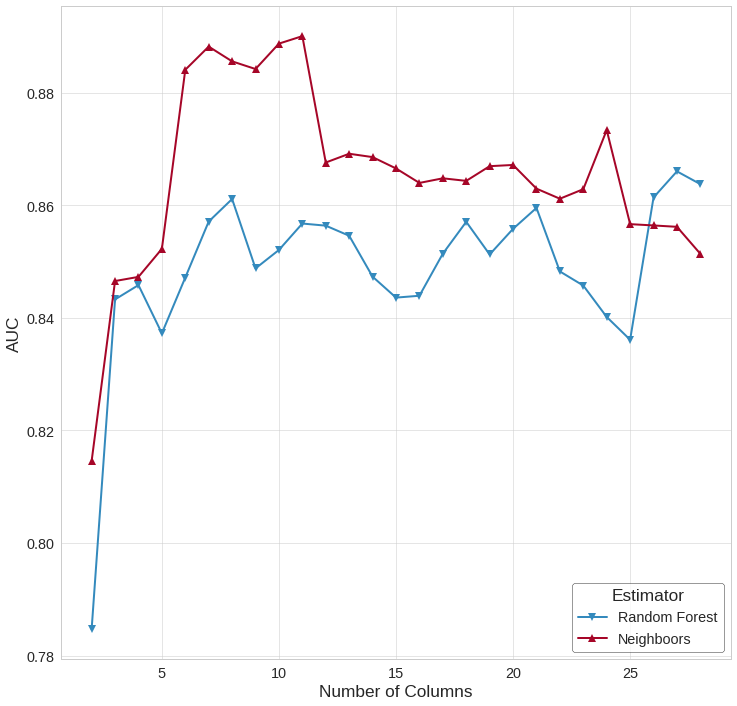

In [481]:
plt.figure(figsize=(12,12))
plt.title('Random Forest and KNeighborsClassifier with columns selected by ExtraTrees',size='xx-large')
plt.xlabel('Number of Columns',size='xx-large')
plt.xticks(size='x-large')
plt.ylabel('AUC',size='xx-large')
plt.yticks(size='x-large')
x = range(2,29)
plt.plot(x,df_aucs_tree.loc['Random Forest'].values,label='Random Forest',marker='v',ms=8)
plt.plot(x,df_aucs_tree.loc['Neighboors'].values,label='Neighboors',marker='^',ms=8)
plt.legend(loc='lower right',frameon=True,title='Estimator',title_fontsize='xx-large',fontsize='x-large',edgecolor='black')
plt.show()